In [5]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the preprocessed dataset with Mel-Spectrograms and MFCCs
raw_ds = load_dataset("ZZZtong/common-accent-MelSpec-MFCC", split="train")

# Encode string accent labels into integer indices
accents = raw_ds.unique("accent")
le = LabelEncoder()
le.fit(accents)
ds = raw_ds.map(lambda ex: {"label": le.transform([ex["accent"]])[0]})

# Split dataset into training and validation sets (stratified by label)
full_df = ds.to_pandas()
train_df, val_df = train_test_split(full_df, test_size=0.2, stratify=full_df["label"], random_state=42)
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "val": Dataset.from_pandas(val_df)
})

# Define a custom collate function to batch variable-size inputs
def collate_fn(batch):
    X = [torch.tensor(ex["mel_spec"]).unsqueeze(0).float() for ex in batch]
    y = [ex["label"] for ex in batch]
    return torch.stack(X), torch.tensor(y)

# Wrap datasets with DataLoaders
train_loader = DataLoader(dataset["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset["val"], batch_size=32, shuffle=False, collate_fn=collate_fn)

# Define a simple CNN model for accent classification
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # 1st Conv block: Input channel = 1, Output = 32
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 2nd Conv block: Input = 32, Output = 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 3rd Conv block: Input = 64, Output = 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Global average pooling to reduce to (batch_size, 128, 1, 1)
            nn.AdaptiveAvgPool2d((1, 1))  
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                    # Flatten the feature map: (128, 1, 1) → (128)
            nn.Dropout(0.5),                 # Dropout for regularization
            nn.Linear(128, num_classes)      # Final classification layer
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model, optimizer, loss function, and scheduler
num_classes = len(le.classes_)
model = ImprovedCNN(num_classes).to(device)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Cross-entropy loss with class weights
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Adam optimizer with learning rate decay
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Reduce learning rate when validation accuracy plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# Evaluation function to compute validation accuracy
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            predicted = preds.argmax(dim=1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

# Training loop
best_val_acc = 0.0
for epoch in range(50):
    model.train()
    total_loss = 0.0
    for X, y in tqdm(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    # Evaluate on validation set
    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)
    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    
    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print(" Best model saved.")


C:\Users\Lu Huang\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 64/64 [01:41<00:00,  1.59s/it]


Epoch 1, Train Loss: 114.4362, Val Acc: 24.80%
✅ Best model saved.


100%|██████████| 64/64 [01:44<00:00,  1.63s/it]


Epoch 2, Train Loss: 110.0458, Val Acc: 35.43%
✅ Best model saved.


100%|██████████| 64/64 [01:43<00:00,  1.62s/it]


Epoch 3, Train Loss: 106.6391, Val Acc: 37.60%
✅ Best model saved.


100%|██████████| 64/64 [01:44<00:00,  1.64s/it]


Epoch 4, Train Loss: 102.2184, Val Acc: 32.68%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 5, Train Loss: 98.3449, Val Acc: 38.58%
✅ Best model saved.


100%|██████████| 64/64 [01:46<00:00,  1.66s/it]


Epoch 6, Train Loss: 96.6871, Val Acc: 37.20%


100%|██████████| 64/64 [01:46<00:00,  1.67s/it]


Epoch 7, Train Loss: 94.5971, Val Acc: 42.72%
✅ Best model saved.


100%|██████████| 64/64 [01:44<00:00,  1.64s/it]


Epoch 8, Train Loss: 92.5848, Val Acc: 36.81%


100%|██████████| 64/64 [01:45<00:00,  1.64s/it]


Epoch 9, Train Loss: 91.7627, Val Acc: 38.98%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 10, Train Loss: 89.9683, Val Acc: 42.13%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 11, Train Loss: 88.7965, Val Acc: 29.72%


100%|██████████| 64/64 [01:46<00:00,  1.66s/it]


Epoch 12, Train Loss: 86.7887, Val Acc: 52.56%
✅ Best model saved.


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 13, Train Loss: 86.2594, Val Acc: 53.15%
✅ Best model saved.


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 14, Train Loss: 84.9616, Val Acc: 51.97%


100%|██████████| 64/64 [01:46<00:00,  1.67s/it]


Epoch 15, Train Loss: 84.5942, Val Acc: 50.59%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 16, Train Loss: 84.7931, Val Acc: 50.59%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 17, Train Loss: 84.2902, Val Acc: 42.32%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 18, Train Loss: 83.0056, Val Acc: 53.15%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 19, Train Loss: 81.9292, Val Acc: 52.17%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 20, Train Loss: 82.9037, Val Acc: 49.80%


100%|██████████| 64/64 [01:49<00:00,  1.71s/it]


Epoch 21, Train Loss: 81.0238, Val Acc: 48.03%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 22, Train Loss: 80.9253, Val Acc: 56.10%
✅ Best model saved.


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 23, Train Loss: 80.4365, Val Acc: 52.95%


100%|██████████| 64/64 [01:46<00:00,  1.67s/it]


Epoch 24, Train Loss: 80.1013, Val Acc: 54.53%


100%|██████████| 64/64 [01:46<00:00,  1.66s/it]


Epoch 25, Train Loss: 80.8045, Val Acc: 52.76%


100%|██████████| 64/64 [01:46<00:00,  1.66s/it]


Epoch 26, Train Loss: 79.7932, Val Acc: 50.39%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 27, Train Loss: 79.6150, Val Acc: 55.12%


100%|██████████| 64/64 [01:46<00:00,  1.66s/it]


Epoch 28, Train Loss: 79.4661, Val Acc: 54.53%


100%|██████████| 64/64 [01:49<00:00,  1.70s/it]


Epoch 29, Train Loss: 78.9704, Val Acc: 53.94%


100%|██████████| 64/64 [01:46<00:00,  1.66s/it]


Epoch 30, Train Loss: 79.0050, Val Acc: 54.33%


100%|██████████| 64/64 [01:46<00:00,  1.66s/it]


Epoch 31, Train Loss: 79.2580, Val Acc: 54.92%


100%|██████████| 64/64 [02:01<00:00,  1.89s/it]


Epoch 32, Train Loss: 78.6304, Val Acc: 54.13%


100%|██████████| 64/64 [01:56<00:00,  1.81s/it]


Epoch 33, Train Loss: 78.7587, Val Acc: 55.31%


100%|██████████| 64/64 [02:02<00:00,  1.91s/it]


Epoch 34, Train Loss: 78.9870, Val Acc: 54.92%


100%|██████████| 64/64 [01:52<00:00,  1.76s/it]


Epoch 35, Train Loss: 79.2229, Val Acc: 55.51%


100%|██████████| 64/64 [01:56<00:00,  1.82s/it]


Epoch 36, Train Loss: 79.4665, Val Acc: 55.51%


100%|██████████| 64/64 [02:11<00:00,  2.05s/it]


Epoch 37, Train Loss: 79.2864, Val Acc: 55.91%


100%|██████████| 64/64 [02:01<00:00,  1.90s/it]


Epoch 38, Train Loss: 78.2283, Val Acc: 55.12%


100%|██████████| 64/64 [01:54<00:00,  1.79s/it]


Epoch 39, Train Loss: 78.5718, Val Acc: 56.30%
✅ Best model saved.


100%|██████████| 64/64 [01:54<00:00,  1.79s/it]


Epoch 40, Train Loss: 77.9646, Val Acc: 55.12%


100%|██████████| 64/64 [01:43<00:00,  1.62s/it]


Epoch 41, Train Loss: 79.0213, Val Acc: 54.33%


100%|██████████| 64/64 [01:44<00:00,  1.64s/it]


Epoch 42, Train Loss: 77.8331, Val Acc: 55.71%


100%|██████████| 64/64 [01:43<00:00,  1.62s/it]


Epoch 43, Train Loss: 78.2883, Val Acc: 54.92%


100%|██████████| 64/64 [01:44<00:00,  1.63s/it]


Epoch 44, Train Loss: 79.1218, Val Acc: 53.74%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 45, Train Loss: 77.9867, Val Acc: 55.91%


100%|██████████| 64/64 [01:44<00:00,  1.64s/it]


Epoch 46, Train Loss: 78.1582, Val Acc: 55.12%


100%|██████████| 64/64 [01:44<00:00,  1.63s/it]


Epoch 47, Train Loss: 79.1447, Val Acc: 54.92%


100%|██████████| 64/64 [01:44<00:00,  1.63s/it]


Epoch 48, Train Loss: 78.5515, Val Acc: 55.31%


100%|██████████| 64/64 [01:45<00:00,  1.65s/it]


Epoch 49, Train Loss: 78.8242, Val Acc: 54.72%


100%|██████████| 64/64 [01:46<00:00,  1.66s/it]


Epoch 50, Train Loss: 78.3647, Val Acc: 55.71%


In [6]:
# Load the test split from the same dataset
test_ds = load_dataset("ZZZtong/common-accent-MelSpec-MFCC", split="test")

# Apply the same label encoder to map accent names to integers
test_ds = test_ds.map(lambda ex: {"label": le.transform([ex["accent"]])[0]})

# Create DataLoader for the test set
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Save the trained model
torch.save(model.state_dict(), "best_improved_model.pt")


In [7]:
# Load the trained model for evaluation
model = ImprovedCNN(num_classes).to(device)
model.load_state_dict(torch.load("best_improved_model.pt"))
model.eval()


C:\Users\LUHUAN~1\AppData\Local\Temp/ipykernel_32500/2824606954.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_improved_model.pt"

ImprovedCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [8]:
# Evaluate on the test set
test_acc = evaluate(model, test_loader)
print(f" Final Test Accuracy: {test_acc * 100:.2f}%")


✅ Final Test Accuracy: 57.61%


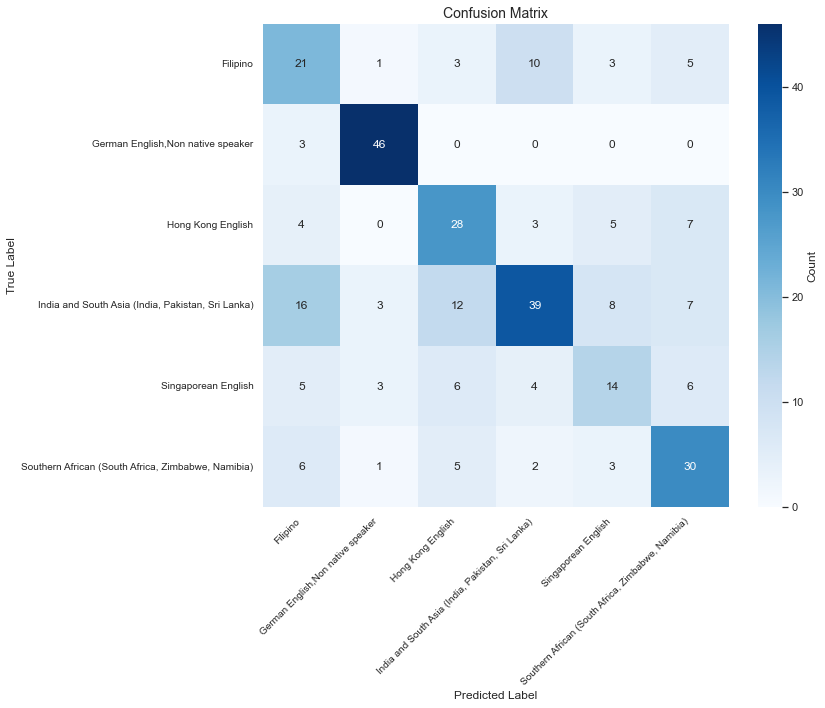

Classification Report:
                                                     precision    recall  f1-score   support

                                          Filipino     0.3818    0.4884    0.4286        43
                 German English,Non native speaker     0.8519    0.9388    0.8932        49
                                 Hong Kong English     0.5185    0.5957    0.5545        47
 India and South Asia (India, Pakistan, Sri Lanka)     0.6724    0.4588    0.5455        85
                               Singaporean English     0.4242    0.3684    0.3944        38
Southern African (South Africa, Zimbabwe, Namibia)     0.5455    0.6383    0.5882        47

                                          accuracy                         0.5761       309
                                         macro avg     0.5657    0.5814    0.5674       309
                                      weighted avg     0.5872    0.5761    0.5736       309



In [12]:
# Import libraries for evaluation metrics and visualization
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Collect true and predicted labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        predicted = preds.argmax(dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = le.classes_


plt.figure(figsize=(12, 10))  
sns.set(font_scale=1.0)      

ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})


plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)


ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(labels, rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# classification report
report = classification_report(y_true, y_pred, target_names=labels, digits=4)
print("Classification Report:\n", report)
